## Overview

This notebook contains a complete implementation of a Gaussian Process Regressor (GPR) with a squared exponential kernel using Numpy for matrix operations and Plotly for visualisation. It is an adaption of the code provided by Fabian Rang from GitLab https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification.

## Packages

In [8]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, widgets
from scipy.special import kv, gamma
import matplotlib.pyplot as plt

## Plotting helper functions

To have nice visualizations of the later GPR, we use Plotly and to have structured and lean code, we define a few commonly used 'helpers' here. 

In [9]:
def update_layout_of_graph(fig: go.Figure,title: str = 'Plot')->go.Figure:
    fig.update_layout(
        width=800,
        height=600,
        autosize=False,
        plot_bgcolor='rgba(0,0,0,0)',
        title=title,
        
    )
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                      xaxis_title = 'input values',
                      yaxis_title = 'output values',
                      legend=dict(yanchor="top",
                                  y=0.9,
                                  xanchor="right",
                                  x=0.95),
                      title={
                          'x': 0.5,
                          'xanchor': 'center'
                      })
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
    return fig

def line_scatter(
    visible: bool = True,
    x_lines: np.array = np.array([]),
    y_lines: np.array = np.array([]),
    name_line: str = 'Predicted function',
    showlegend: bool = True,
) -> go.Scatter:
    # Adding the lines
    return go.Scatter(
        visible=visible,
        line=dict(color="blue", width=2),
        x=x_lines,
        y=y_lines,
        name=name_line,
        showlegend= showlegend
    )

def dot_scatter(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'Observed points',
    showlegend: bool = True
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        mode="markers",
        name=name_dots,
        marker=dict(color='red', size=8),
        showlegend=showlegend
    )

def uncertainty_area_scatter(
        visible: bool = True,
        x_lines: np.array = np.array([]),
        y_upper: np.array = np.array([]),
        y_lower: np.array = np.array([]),
        name: str = "mean plus/minus standard deviation",
) -> go.Scatter:

    return go.Scatter(
        visible=visible,
        x=np.concatenate((x_lines, x_lines[::-1])),  # x, then x reversed
        # upper, then lower reversed
        y=np.concatenate((y_upper, y_lower[::-1])),
        fill='toself',
        fillcolor='rgba(189,195,199,0.5)',
        line=dict(color='rgba(200,200,200,0)'),
        hoverinfo="skip",
        showlegend=True,
        name= name,
    )

def add_slider_GPR(figure: go.Figure, parameters):
    figure.data[0].visible = True
    figure.data[1].visible = True

    # Create and add slider
    steps = []
    for i in range(int((len(figure.data) - 1) / 2)):
        step = dict(
            method="update",
            label=f'{parameters[i]: .2f}',
            args=[{
                "visible": [False] * (len(figure.data) - 1) + [True]
            }],
        )
        step["args"][0]["visible"][2 *
                                   i] = True  # Toggle i'th trace to "visible"
        step["args"][0]["visible"][2 * i + 1] = True
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps,
    )]
    figure.update_layout(sliders=sliders, )
    return figure

def add_slider_to_function(figure:go.Figure, parameters):
    figure.data[0].visible = True

    # Create and add slider
    steps = []
    for i in range(len(figure.data)):
        step = dict(
            method="update",
            label=f'{parameters[i]: .2f}',
            args=[{
                "visible": [False] *len(figure.data) 
            }],
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps,
    )]
    figure.update_layout(sliders=sliders, )
    return figure

## Implementation of GPR with squared exponential kernel

In order to define a Gaussian Process Regressor (GPR), we need a covariance function (also called a kernel). The choice of this function determines the "shape" of the GPR and influences how the model generalizes to unseen data. Below are some commonly used kernels as stated in Rasmussen Table 4.1.:

### 1. Squared Exponential Kernel
The **squared exponential kernel** is widely used in Gaussian Process models and is defined as:
$$ k(x_1, x_2) := \sigma^2 \exp\left(-\frac{\|x_1 - x_2\|^2_2}{2 l^2}\right) $$
where $ l > 0 $ is the length scale and  $\sigma^2 > 0$ is the signal variance.

- $ \sigma $ controls the amplitude of variation in the function.
- $ l $ controls the smoothness of the function, with smaller values making the function decay more rapidly with distance, while larger values smooth it out.

### 2. Constant Kernel
The **constant kernel** is defined as:
$$ k(x_1, x_2) := \sigma_0^2 $$
where $ \sigma_0^2 $ is a constant.

This kernel is **stationary** but **degenerate** (more on that in 4.2.1), meaning it produces covariance matrices with finite rank, which limits its flexibility. Degenerate matrices have finite rank, resulting in limited expressiveness. The constant kernel is useful for modeling functions that are approximately constant across the input space. I find it mostly interesting to see what other kernels do, therefore this primitive selection.

### 3. Matérn Kernel
The **Matérn kernel** is a more general kernel with the **squared exponential kernel**. It is defined as:
$$ k(x_1, x_2) := \frac{1}{2^{\nu-1} \Gamma(\nu)} \left( \frac{\sqrt{2 \nu} \, \|x_1 - x_2\|}{l} \right)^\nu K_\nu \left( \frac{\sqrt{2 \nu} \, \|x_1 - x_2\|}{l} \right) $$
where:
- $ l $  is the length scale.
- $ \nu > 0 $ controls the smoothness of the function, with higher values of $ \nu $ making the function smoother.
- $ K_\nu $ is the modified Bessel function of the second kind. (I don't know what that is but I will keep it because it may be interesting to try out a highly complicated model)
- $ \Gamma $ is the gamma function.

The Matérn kernel is often chosen for applications where controlling the smoothness of the function is important, as it allows for a range of behaviors. With $ \nu = 0.5 $, the Matérn kernel becomes equivalent to the exponential kernel (that we did not cover here but it also a classic), and as $ \nu \to \infty $, it approaches the squared exponential kernel. (Source: https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function).

In [10]:
class SquaredExponentialKernel:
    def __init__(self, sigma_f: float = 1, length: float = 1):
        self.sigma_f = sigma_f
        self.length = length

    def __call__(self, argument_1: np.array, argument_2: np.array) -> float:
        return float(self.sigma_f *
                     np.exp(-(np.linalg.norm(argument_1 - argument_2)**2) /
                            (2 * self.length**2)))
    
class ConstantKernel:
    def __init__(self, sigma_0: float = 1):
        self.sigma_0 = sigma_0
    
    def __call__(self, argument_1: np.array, argument_2: np.array) -> float:
        return(self.sigma_0 ** 2)
    
class MaternKernel:
    def __init__(self, sigma_f: float = 1, length: float = 1, nu: float = 1.5):
        self.sigma_f = sigma_f
        self.length = length
        self.nu = nu

    def __call__(self, argument_1: np.array, argument_2: np.array) -> float:
        r = np.linalg.norm(argument_1 - argument_2) #Euclidean distance between the two points
        
        # Special case for r = 0 to avoid division by zero
        if r == 0.0:
            return self.sigma_f ** 2
        
        # Calculate the kernel value based on the Matérn function formula
        factor = (2 ** (1 - self.nu)) / gamma(self.nu)
        scaled_distance = (np.sqrt(2 * self.nu) * r) / self.length
        bessel_term = kv(self.nu, scaled_distance)  # Modified Bessel function of the second kind
        
        return float(self.sigma_f ** 2 * factor * (scaled_distance ** self.nu) * bessel_term)

Let us visualize these kernels. We will start with the **squared exponential kernel**.

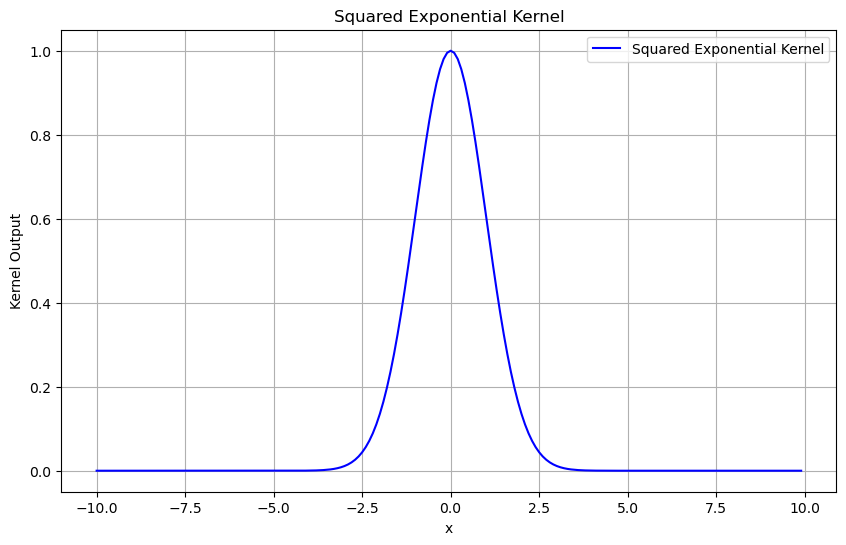

In [11]:
# Define fixed parameters for length and argument_2
length = 1.0  # Set the length directly
argument_2 = 0  # Set argument_2 directly

# Generate x values
x_lines = np.arange(-10, 10, 0.1)

# Initialize kernel
kernel = SquaredExponentialKernel(length=length)

# Compute y values using fixed argument_2
y_lines = np.array([kernel(x, argument_2) for x in x_lines])

# Plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(x_lines, y_lines, label="Squared Exponential Kernel", color="blue")
plt.title("Squared Exponential Kernel")
plt.xlabel("x")
plt.ylabel("Kernel Output")
plt.legend()
plt.grid(True)
plt.show()

Let us shortly recall the formula:
Given training points $\mathbf{x}_1, \dots, \mathbf{x}_n \in \mathbb{R}^m$ with values $y_1, \dots, y_n \in \mathbb{R}$, $\mathbf{y} = (y_i) \in \mathbb{R}^n$ with noise in each point $\mathcal{N} \sim (0, \sigma_n)$, and points $\mathbf{x}_{n+1}, \dots, \mathbf{x}_k \in \mathbb{R}^m$ for which we want to predict the output, adapting our probability distribution leads to:

$$
f_* | X_*, X, y \sim \mathcal{N}\left(K(X, X_*) \cdot (K(X, X) + \sigma^2 \cdot I)^{-1} \cdot \mathbf{y},
K(X_*, X_*) - K(X, X_*) \cdot (K(X, X) + \sigma^2 \cdot I)^{-1} \cdot K(X, X_*)\right)
$$

where $K : (\mathbb{R}^m)^k \times (\mathbb{R}^m)^l \to \mathbb{R}^{k \times l}$ is defined as the matrix:

$$
K(X, X') = \begin{bmatrix}
    k(\mathbf{x}_1, \mathbf{x}'_1) & \dots & k(\mathbf{x}_1, \mathbf{x}'_l) \\
    \vdots & \ddots & \vdots \\
    k(\mathbf{x}_k, \mathbf{x}'_1) & \dots & k(\mathbf{x}_k, \mathbf{x}'_l)
\end{bmatrix}
$$

the covariance matrix of $X$ and $X'$ with $X, X' \in \{X, X_*\}$. This can either be the covariance matrix of training data $K(X, X)$, of test data $K(X_*, X_*)$, or of training with test data $K(X, X_*)$. $\sigma_n$ is some noise parameter which makes sense as one should not assume $y=f(x)$ for our purposes but some error $y=f(x)+\epsilon$. For the noise free case, set $\sigma_n=0$.

DERIVE $f_* | X_*, X, y$. Understand why transpose!

In [12]:
# Helper function to calculate the respective covariance matrices
def cov_matrix(x1, x2, cov_function) -> np.array:
    return np.array([[cov_function(a, b) for a in x1] for b in x2])

In [13]:
class GPR:
    def __init__(self, data_x, data_y, covariance_function=SquaredExponentialKernel(), white_noise_sigma: float = 0):
        self.noise = white_noise_sigma
        self.data_x = data_x
        self.data_y = data_y
        self.covariance_function = covariance_function

        # Store the inverse of covariance matrix of input since it is needed for every prediction
        self._inverse_of_covariance_matrix_of_input_noise_adj = np.linalg.inv(
            cov_matrix(data_x, data_x, covariance_function) + self.noise * np.identity(len(self.data_x)))

        self._memory = None  # Will later store a dictionary containing mean, covariance matrix, and variance of the predictions.

    # Function to predict output at new input values. Store the mean and covariance matrix in memory.
    def predict(self, test_data: np.ndarray) -> np.ndarray:
        # Calculate covariance matrices
        KXX_star = cov_matrix(test_data, self.data_x, self.covariance_function)  # K(X, X_*)
        KXX_star = KXX_star.T
        # Check if KXX_star has fewer rows than columns
        #if KXX_star.shape[0] < KXX_star.shape[1]:
            
        #    print("Transposed KXX_star to match required shape. New shape:", KXX_star.shape)
        #else:
        #    print("KXX_star shape is suitable, no transpose needed:", KXX_star.shape)

        KX_starX_star = cov_matrix(test_data, test_data, self.covariance_function)  # K(X_*, X_*)

        # Mean prediction using formula: K(X, X_*) * (K(X, X) + sigma^2 * I)^(-1) * y
        #Debug
        print("Debugging shape dimensions:")
        print(f"KXX_star shape: {KXX_star.shape}, expected shape: (number of test points, number of data points)")
        print(f"Inverse of covariance matrix shape: {self._inverse_of_covariance_matrix_of_input_noise_adj.shape}, expected shape: ({len(self.data_x)}, {len(self.data_x)})")
        print(f"Data_y shape: {self.data_y.shape}, expected shape: ({len(self.data_x)},)")
        print(f"Resulting shape of (inverse covariance matrix * data_y): {(self._inverse_of_covariance_matrix_of_input_noise_adj @ self.data_y).shape}")
        mean_test_data = KXX_star @ (self._inverse_of_covariance_matrix_of_input_noise_adj @ self.data_y)  # in n x 1

        # Covariance prediction using formula: K(X_*, X_*) - K(X, X_*) * (K(X, X) + sigma^2 * I)^(-1) * K(X, X_*)^T
        cov_test_data = KX_starX_star - KXX_star @ (self._inverse_of_covariance_matrix_of_input_noise_adj @ KXX_star.T)  # in n x n

        # Variance (diagonal elements of the covariance matrix).
        var_test_data = np.diag(cov_test_data)  # in n x 1

        # Store results in memory
        self._memory = {
            'mean': mean_test_data,
            'covariance_matrix': cov_test_data,
            'variance': var_test_data
        }
        
        return mean_test_data

That's it. The GPR is ready to be used! 

## Testing

Let us initialize our GPR on a set of values and visualize the GPR. 

### Initializing training data

In [16]:
x_values = np.array([0, 0.3, 1, 3.1, 4.7])
y_values = np.array([1, 0, 1.4, 0, -0.9])
x = np.arange(-1, 7, 0.1)

### Plot the output

Let us define a helper function which returns a list of all plots of data points, mean, etc. needed to plot a GPR.

In [17]:
def plot_GPR(data_x, data_y, model, x, visible=True) -> list:
    mean = model.predict(x)

    std = np.sqrt(model._memory['variance'])
    data = []

    for i in range(1, 4):
        data.append(
            uncertainty_area_scatter(
                x_lines=x,
                y_lower=mean - i * std,
                y_upper=mean + i * std,
                name=f"mean plus/minus {i}*standard deviation",
                visible=visible))

    data.append(line_scatter(x_lines=x, y_lines=mean, visible=visible))
    data.append(dot_scatter(x_dots=data_x, y_dots=data_y, visible=visible))
    return data

Now, we can visualize our first GPR.

In [18]:
model = GPR(x_values, y_values)
data = plot_GPR(data_x=x_values, data_y=y_values, x=x, model=model)
fig4 = go.Figure(data=data)
fig4 = update_layout_of_graph(fig=fig4,
                              title='GPR with length 1, sigma 0 and noise 0')

fig4.show()

Debugging shape dimensions:
KXX_star shape: (80, 5), expected shape: (number of test points, number of data points)
Inverse of covariance matrix shape: (5, 5), expected shape: (5, 5)
Data_y shape: (5,), expected shape: (5,)
Resulting shape of (inverse covariance matrix * data_y): (5,)


### Visualization of effect of free parameters

Awesome! Now that we can make predictions with our GPR, lets visualize how the GPR changes if we change the free parameters, i.e. length-scale, variance and white noise.

In [ ]:
model = GPR(x_values,
            y_values,
            covariance_function=SquaredExponentialKernel(length=0.5),
            white_noise_sigma=0.1)

data = plot_GPR(x_values, y_values, model=model, x=x)

fig3 = go.FigureWidget(data=data)


# we update the y values of our 4 scatter plots 
@interact(sigma=(0.01, 3, 0.01), length=(0.01, 3, 0.01), noise=(0, 3, 0.1))
def update(sigma=1, length=0.5, noise=0.1):
    with fig3.batch_update():
        model = GPR(x_values,
                    y_values,
                    covariance_function=SquaredExponentialKernel(
                        sigma_f=sigma, length=length),
                    white_noise_sigma=noise)

        mean = model.predict(x)
        y_upper = mean + np.sqrt(model._memory['variance'])
        y_lower = mean - np.sqrt(model._memory['variance'])

        
        for i in range(1, 4):
            y_upper = mean + i * np.sqrt(model._memory['variance'])
            y_lower = mean - i * np.sqrt(model._memory['variance'])
            fig3.data[i-1].y = np.concatenate((y_upper, y_lower[::-1]))
        
        fig3.data[3].y = mean


fig3 = update_layout_of_graph(
    fig3, title="GPR with varying length, sigma and white noise")
fig3

Debugging shape dimensions:
KXX_star shape: (80, 5), expected shape: (number of test points, number of data points)
Inverse of covariance matrix shape: (5, 5), expected shape: (5, 5)
Data_y shape: (5,), expected shape: (5,)
Resulting shape of (inverse covariance matrix * data_y): (5,)


interactive(children=(FloatSlider(value=1.0, description='sigma', max=3.0, min=0.01, step=0.01), FloatSlider(v…

## Application in the paper


Now that we saw a bit about arbitraty values. So where is the application of the paper? Well, we will start with it now. Firstly, we will not replicate any functions used in the paper is this is unneccessary complex. We want to emphazise what can be done by looking at a simple option pricing formula. As my functions are too simple and don't do hyperparameter optimization I decided to rely on code provided by rasmussen via their Octave package, downloadable here: https://gaussianprocess.org/gpml/code/matlab/doc/.